In [36]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [37]:
data = pd.read_csv('Month_Value_1.csv', index_col=[0],
                            parse_dates=[0])

data.sort_index(inplace=True)

data.head(3)

,Revenue,Sales_quantity,Average_cost,The_average_annual_payroll_of_the_region
Period,,,,
2015-01-01,1.601007e+07,12729,1257.763541,30024676
2015-01-02,1.580759e+07,11636,1358.507000,30024676
2015-01-03,2.204715e+07,15922,1384.697024,30024676


In [38]:
data = data.drop(['Revenue', 'Average_cost', 'The_average_annual_payroll_of_the_region'], axis= 1)

In [39]:
data.head()

,Sales_quantity
Period,
2015-01-01,12729
2015-01-02,11636
2015-01-03,15922
2015-01-04,15227
2015-01-05,8620


In [40]:
def split_data(data, split_date):
    return data[data.index <= split_date].copy(), \
           data[data.index >  split_date].copy()

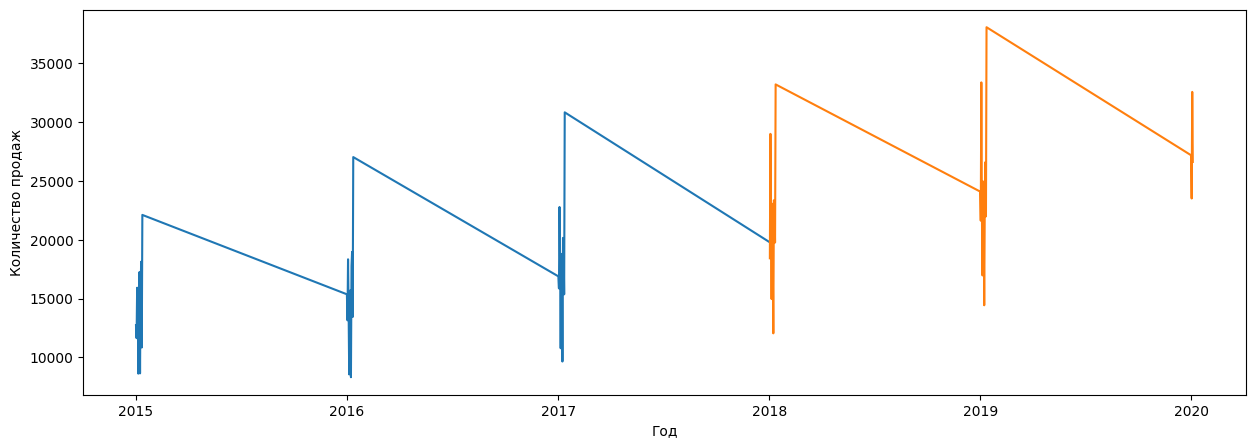

In [41]:
train, test = split_data(data, '01-Jan-2018')

plt.figure(figsize=(15,5))
plt.xlabel('Год')
plt.ylabel('Количество продаж')
plt.plot(train.index,train)
plt.plot(test.index,test)
plt.show()

In [42]:
def create_features(df):
    """
    Делаем фичи из индекса datetime
    """
    df['date'] = df.index
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    #df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth']]
    return X

In [43]:
X_train, y_train = create_features(train), train['Sales_quantity']
X_test, y_test   = create_features(test), test['Sales_quantity']

X_train.shape, y_train.shape

((37, 6), (37,))

In [44]:
X_train.head()

,dayofweek,quarter,month,year,dayofyear,dayofmonth
Period,,,,,,
2015-01-01,3,1,1,2015,1,1
2015-01-02,4,1,1,2015,2,2
2015-01-03,5,1,1,2015,3,3
2015-01-04,6,1,1,2015,4,4
2015-01-05,0,1,1,2015,5,5


In [45]:
reg = xgb.XGBRegressor()

In [46]:
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
        verbose=False)

C:\Users\aw347\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [47]:
importances = reg.get_booster().get_score(importance_type='weight')
feature_importances = pd.Series(importances, index=X_train.columns).sort_values()

In [48]:
print(feature_importances)

year          342.0
dayofyear     788.0
dayofweek     897.0
quarter         NaN
month           NaN
dayofmonth      NaN
dtype: float64


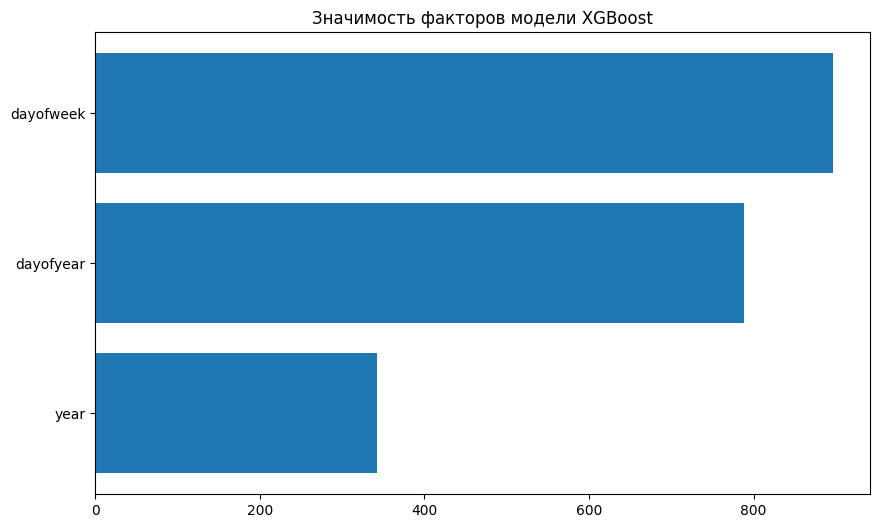

In [49]:
plt.figure(figsize=(10, 6))
plt.barh(feature_importances.index, feature_importances.values)
plt.title('Значимость факторов модели XGBoost')
plt.show()

In [50]:
def plot_performance(base_data, date_from, date_to, title=None):
    plt.figure(figsize=(15,3))
    if title == None:
        plt.title('Прогноз на интервале от {0} до {1}'.format(date_from, date_to))
    else:
        plt.title(title)
    plt.xlabel('Год')
    plt.ylabel('Объем продаж')
    plt.plot(data.index,data, label='Исходные данные')
    plt.plot(X_test.index,X_test_pred, label='Прогноз')
    plt.legend()
    plt.xlim(left=date_from, right=date_to)

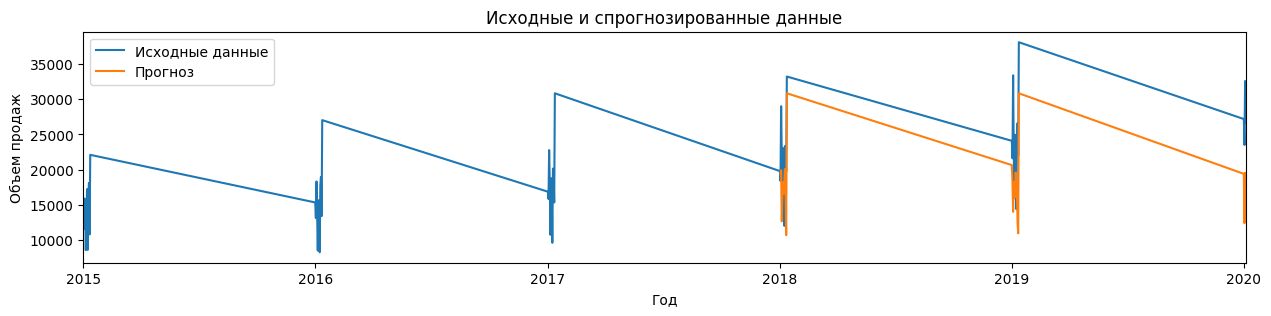

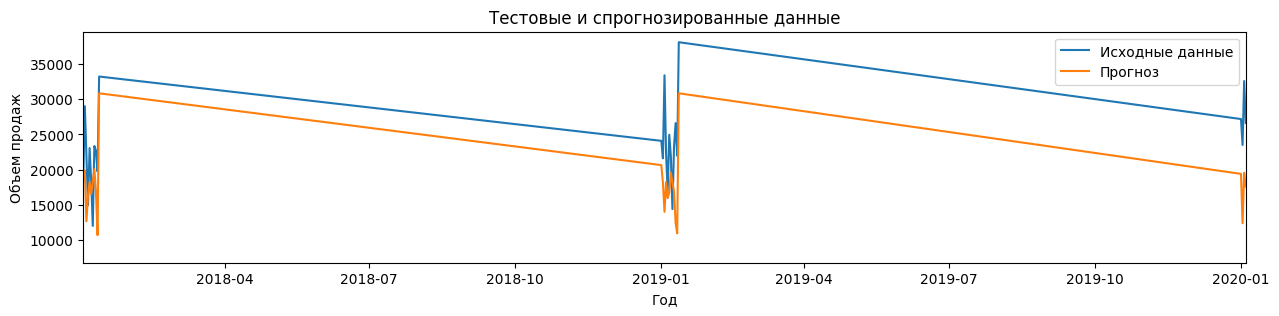

In [51]:
X_test_pred = reg.predict(X_test)
    
plot_performance(data, data.index[0].date(), data.index[-1].date(),
                 'Исходные и спрогнозированные данные')

plot_performance(y_test, y_test.index[0].date(), y_test.index[-1].date(),
                 'Тестовые и спрогнозированные данные')

plt.legend()

plt.show()

C:\Users\aw347\AppData\Local\Temp\ipykernel_10084\3746914004.py:12: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim(left=date_from, right=date_to)


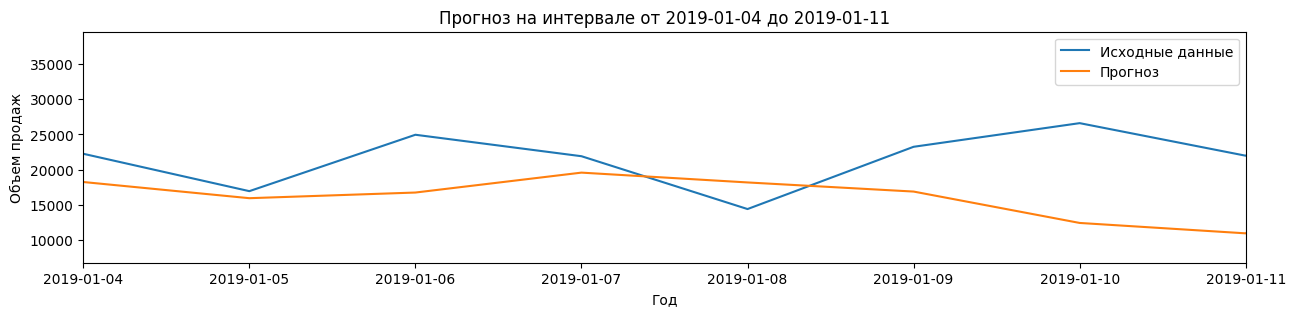

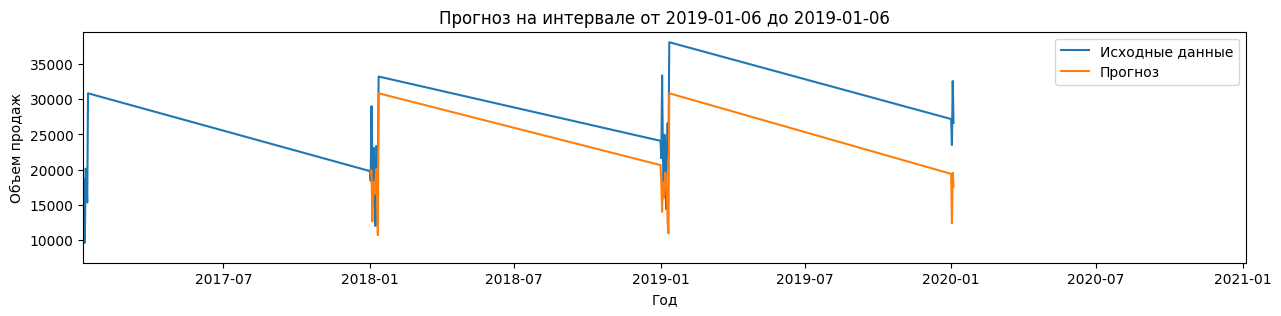

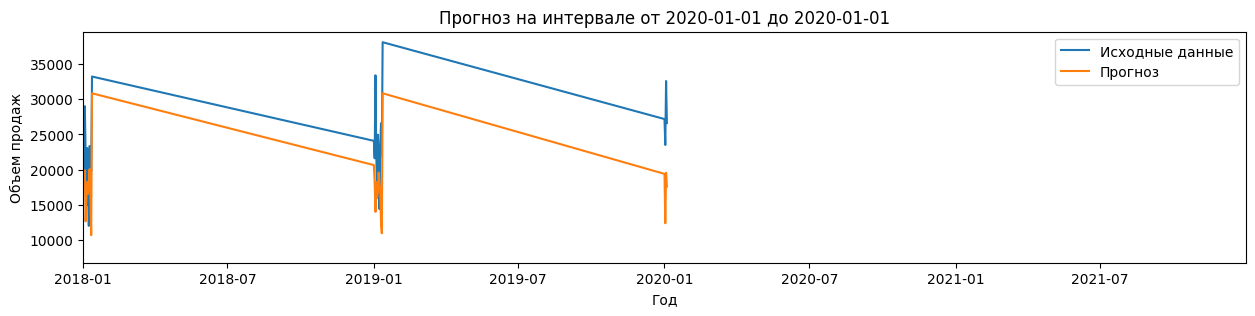

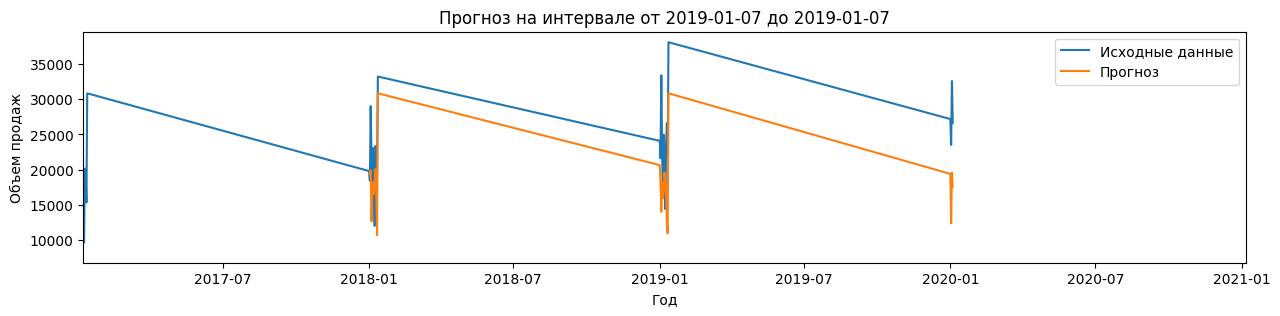

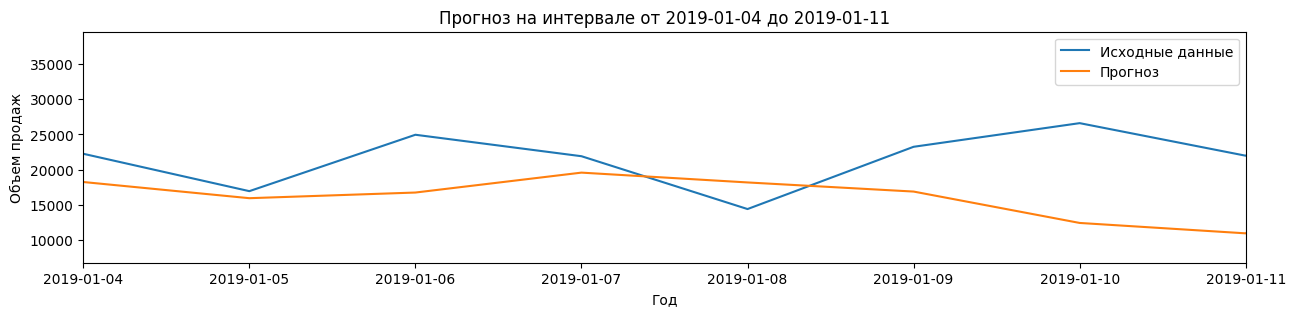

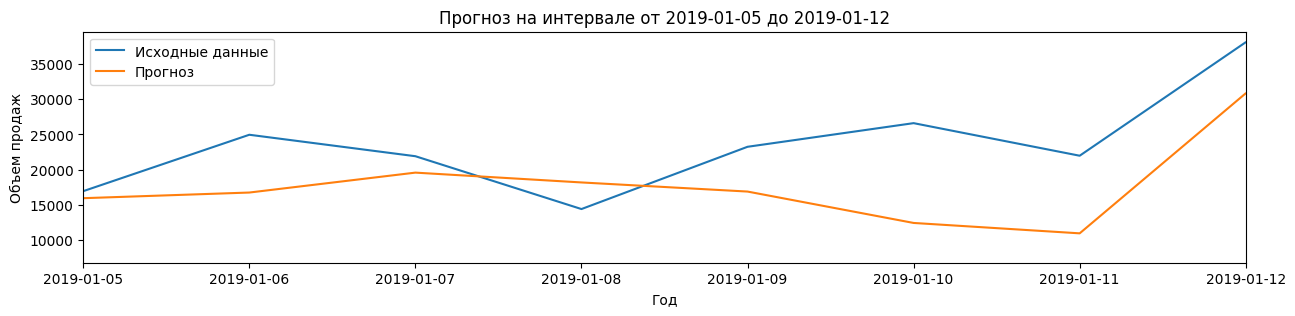

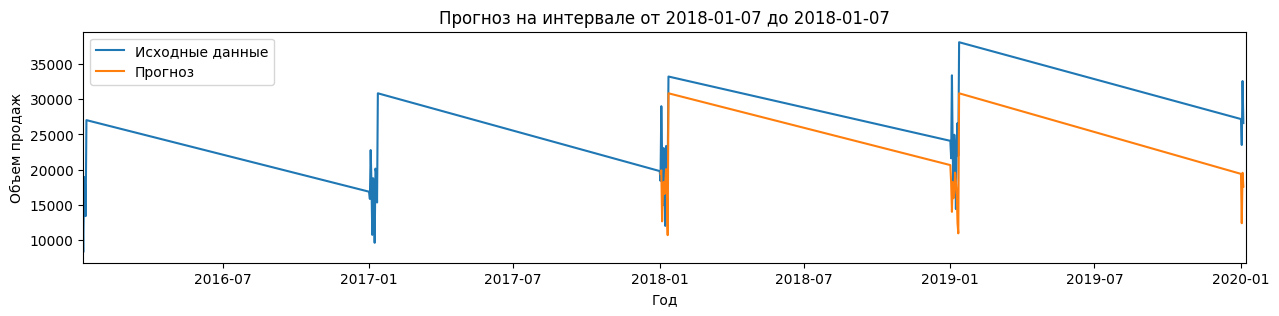

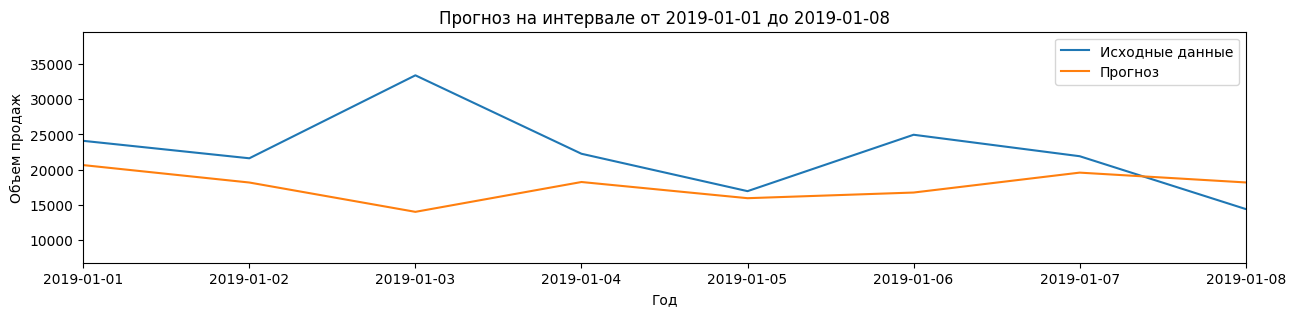

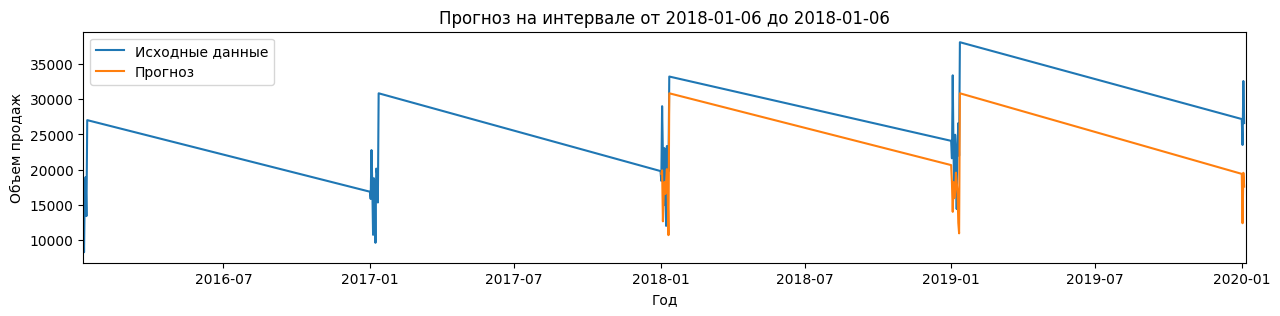

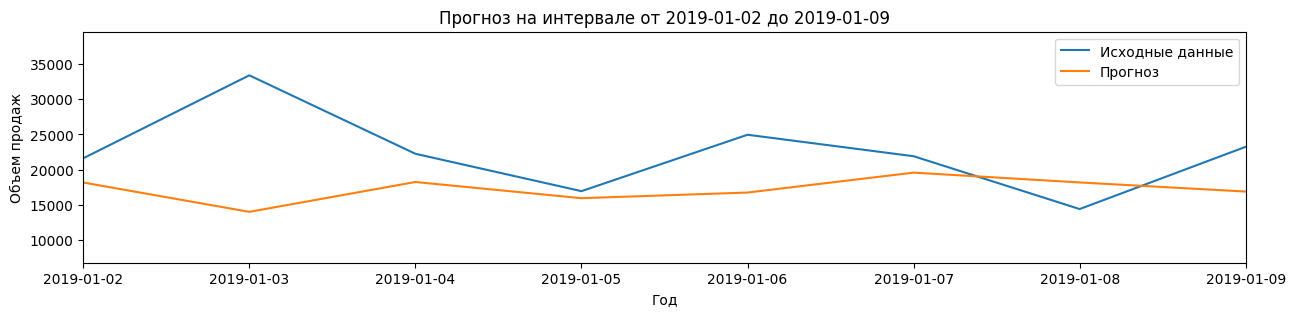

In [52]:
random_weeks = X_test[['year', 'dayofweek']].sample(10)
for week in random_weeks.iterrows():
    index = (X_test.year == week[1].year) & \
    (X_test.dayofweek == week[1].dayofweek)
    d = y_test[index]
    plot_performance(d, d.index[0].date(), d.index[-1].date())

In [53]:
mean_squared_error(y_true=y_test,
                   y_pred=X_test_pred)

63581792.56897715

In [54]:
mean_absolute_error(y_true=y_test,
                   y_pred=X_test_pred)

6635.421730324074

In [55]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Рассчитываем MAPE"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [56]:
mean_absolute_percentage_error(y_test,X_test_pred)

27.539570737300416

In [57]:
error_by_dweek = []
random_dweeks = X_test[['year', 'dayofweek']].sample(10)
for dweek in random_dweeks.iterrows():
    index = (X_test.year == week[1].year) & \
            (X_test.dayofweek == week[1].dayofweek)
    error_by_dweek.append(mean_absolute_percentage_error(y_test[index], X_test_pred[index]))
pd.Series(error_by_dweek, index=random_weeks.index)

Period
2019-01-04    21.580937
2019-01-06    21.580937
2020-01-01    21.580937
2019-01-07    21.580937
2019-01-11    21.580937
2019-01-12    21.580937
2018-01-07    21.580937
2019-01-01    21.580937
2018-01-06    21.580937
2019-01-02    21.580937
dtype: float64